# Seminar 8 (part 2): Functional connectivity

**Plan**

- **Goal.** Use resting-state fMRI and connectivity analysis to understand large-scale brain networks and to predict clinical diagnosis (schizophrenia vs control).  

- **Libraries & Tools.**  
  - [fMRIPrep](https://fmriprep.org/) — standardized preprocessing of fMRI data.  
  - [Nilearn](https://nilearn.github.io/) — analysis and visualization of fMRI, time series extraction, connectivity measures.  

- **Dataset.** [COBRE dataset](http://fcon_1000.projects.nitrc.org/indi/retro/cobre.html): schizophrenia patients and healthy controls. Preprocessed BOLD signals, aggregated into ROIs.  

- **Workflow preview.**  
  1. **Visualize data** with Nilearn (mean image, parcellations, time series).  
  2. **Extract ROI signals** (Region of Interest time series).  
  3. **Build connectivity matrices** (Pearson/Spearman correlation, shrinkage estimators, mutual information).  
  4. **Extract features**:  
     - Topological (persistent homology, Betti curves)  
     - Graph-based (degree, centrality, efficiency)  
     - Spectral (Laplacian eigenvalues)  
  5. **Train ML models** (e.g., logistic regression, SVM) to classify schizophrenia vs healthy control.  
  6. **Homework description**: compare different connectivity estimation methods, apply feature selection and dimensionality reduction, and write a short report on which pipeline works best and why.  

In [1]:
! pip install nilearn

In [2]:
! pip install diagram2vec

  Using cached diagram2vec-0.0.2-py3-none-any.whl.metadata (2.7 kB)
Using cached diagram2vec-0.0.2-py3-none-any.whl (5.1 kB)


In [3]:
import os
import re

import pandas as pd
import numpy as np

import nibabel as nib

import nilearn
from nilearn.image import concat_imgs
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import high_variance_confounds
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets
from nilearn import plotting
from nilearn.image import mean_img

import matplotlib.pyplot as plt

import numpy as np
import networkx as nx 
import nilearn # pip install nilearn
from scipy.stats import spearmanr
from sklearn.metrics import mutual_info_score
import warnings
warnings.filterwarnings("ignore")
from nilearn import image
import glob
from pathlib import Path

#  Dataset source

In [4]:
%matplotlib inline

We will use preprocessed COBRE resting-state fMRI data.  
The dataset is available at: [Yandex Disk link](https://disk.yandex.com.am/d/C78Cm3uS54dJRg).  

Tip: for convenience, you may add a shortcut to your Google Drive and work directly from there.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Here we choose one subject (`sub-A00000368`) and construct the full file path to the preprocessed resting-state BOLD NIfTI file.  

This is useful for testing the pipeline on a single participant before looping through all subjects.

In [8]:
subj_id ="sub-A00000368"

In [9]:
fmri_filename =f"./cobre/{subj_id}/func/{subj_id}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

We load the 4D fMRI image (X × Y × Z × T).  
- The first three numbers are spatial dimensions.  
- The last number (`T`) is the number of time points (TRs).  

This helps confirm the data were loaded correctly and gives us a sense of the scan length.

In [10]:
fmri_image =image.load_img(fmri_filename)

In [11]:
print(fmri_image.shape)

(53, 62, 44, 150)


In [12]:
first_slice = image.index_img(fmri_image, 0)
print(first_slice.shape)

(53, 62, 44)


##  View the first time point

We extract the very first 3D volume (`t=0`) from the 4D fMRI data.  
Visualizing this is a basic sanity check:  
- Does the brain appear properly aligned?  
- Are there any obvious artifacts or problems in orientation?  


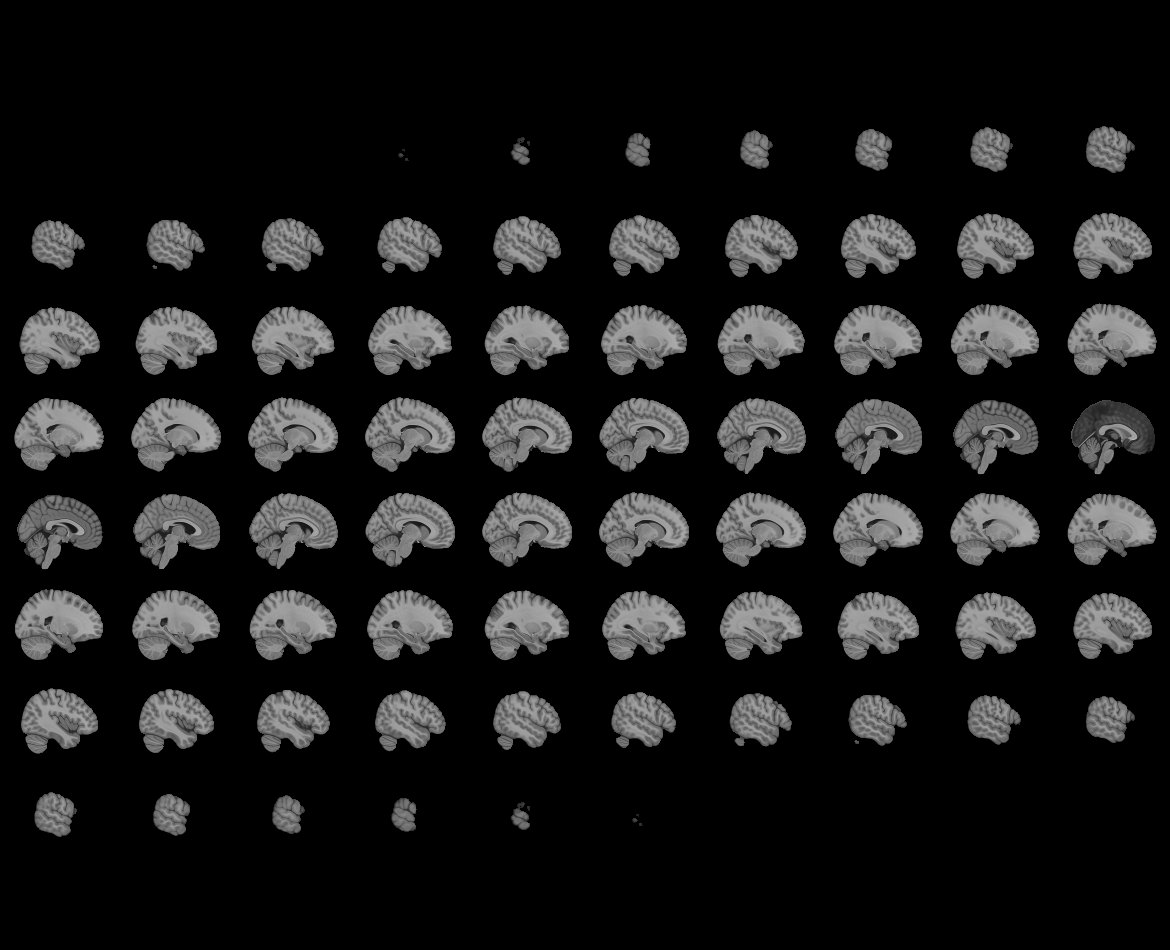
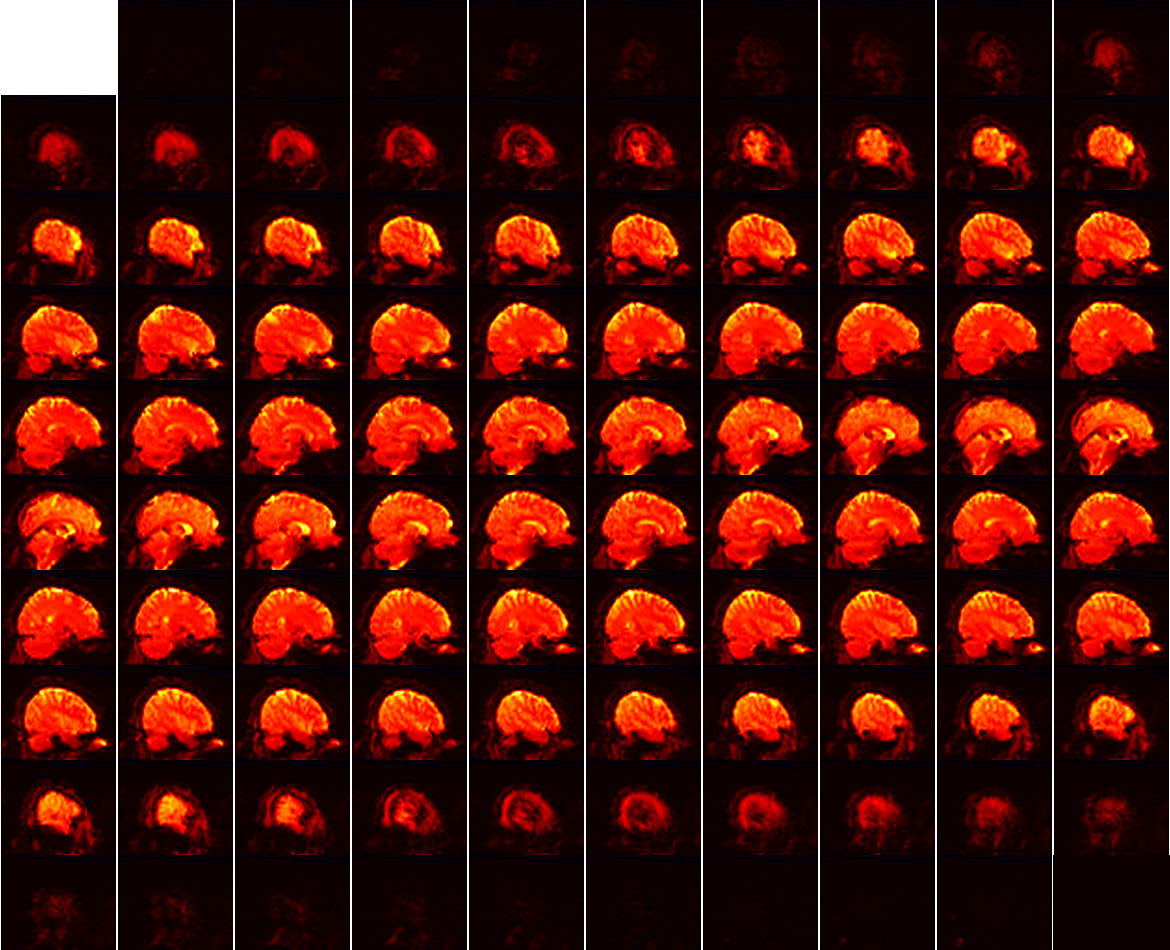

In [13]:
plotting.view_img(first_slice, threshold=None)

## View the mean image over time


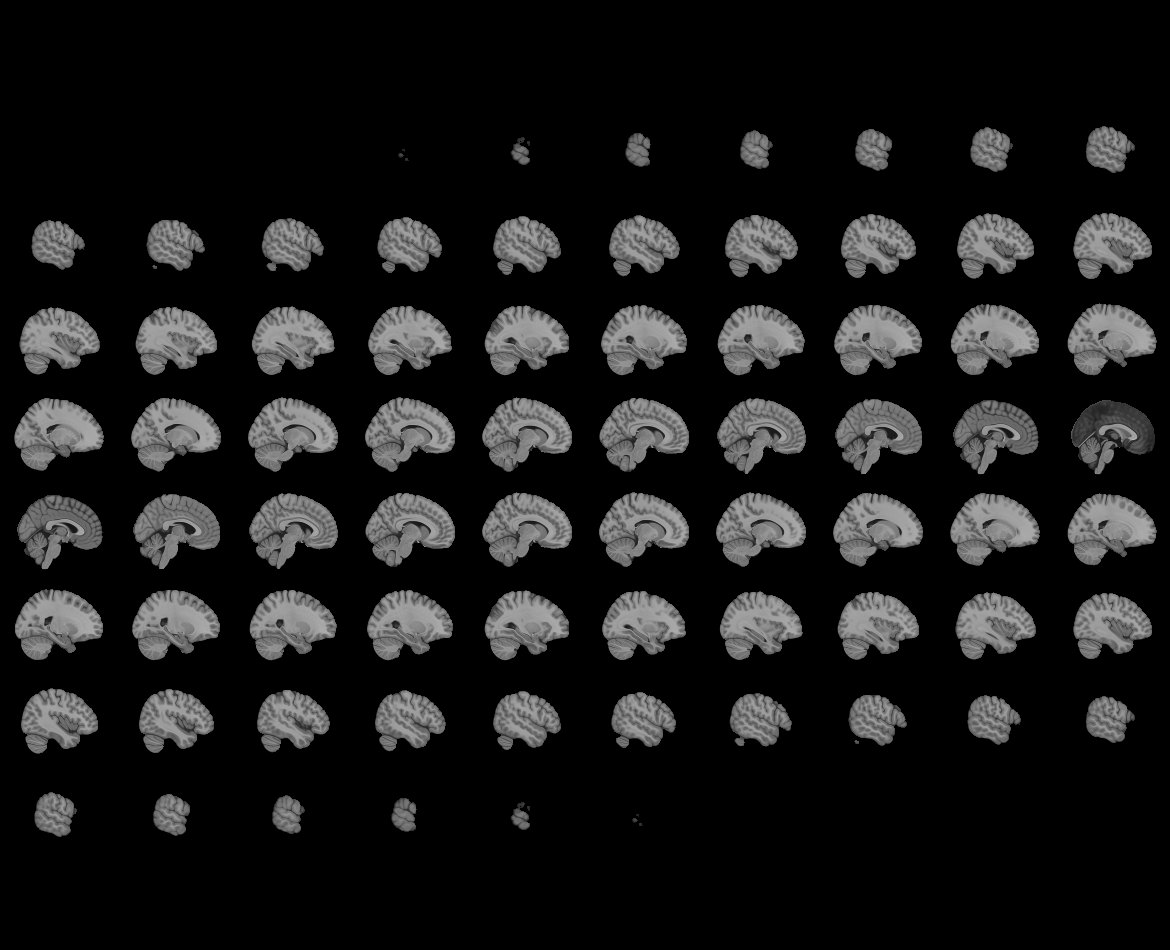
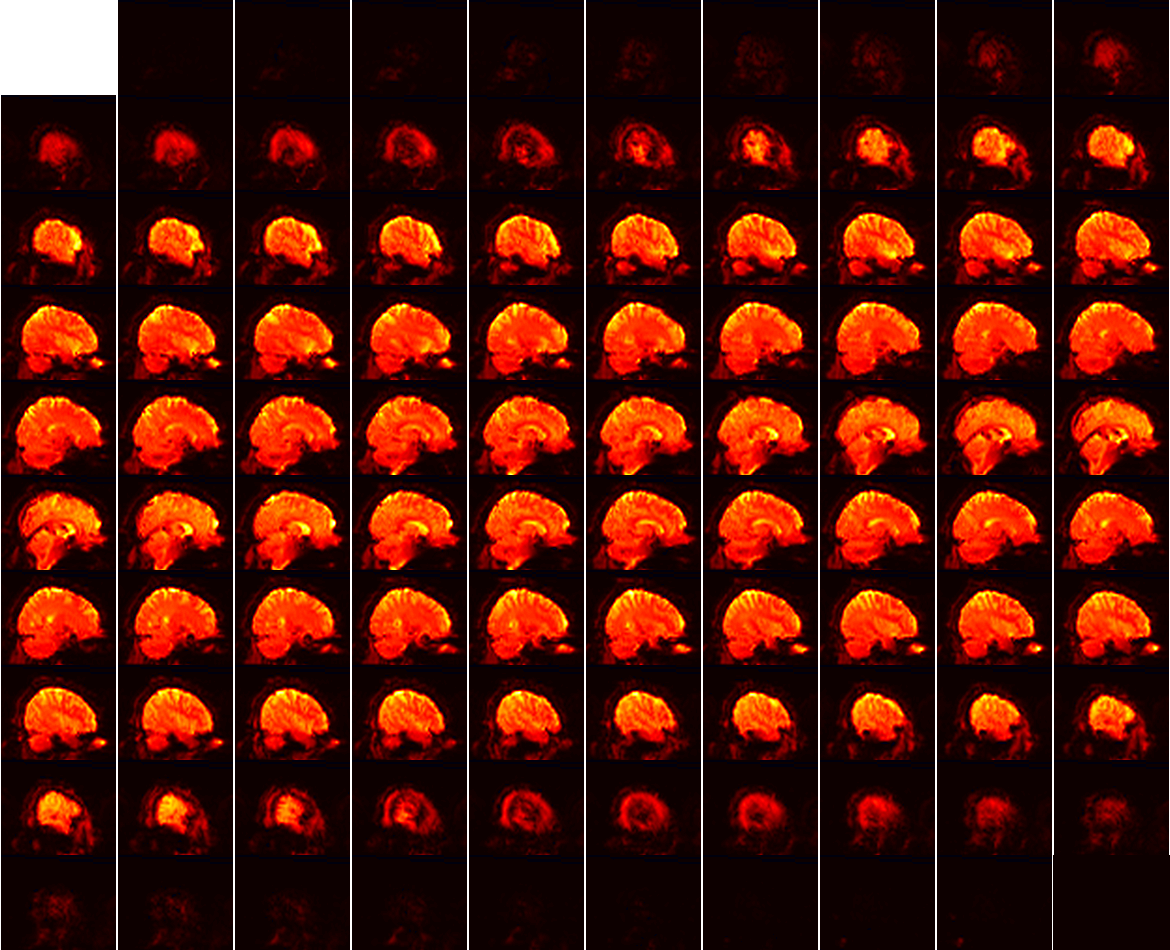

In [14]:
plotting.view_img(mean_img(fmri_filename), threshold=None)

Averaging across all time points reduces noise and shows a clearer structural outline.  
The mean image is often used for quality control (QC) and for alignment with atlases or ROIs.

## Load and visualize the AAL atlas


We use the **AAL (Automated Anatomical Labeling)** atlas.  
- Each color represents a brain region (ROI).  
- Signals from all voxels in a region will be aggregated later.  

This step introduces the concept of *parcellation*: dividing the brain into meaningful regions.

In [15]:
aal_atlas =datasets.fetch_atlas_aal()
atlas_img =nib.load(aal_atlas.maps)

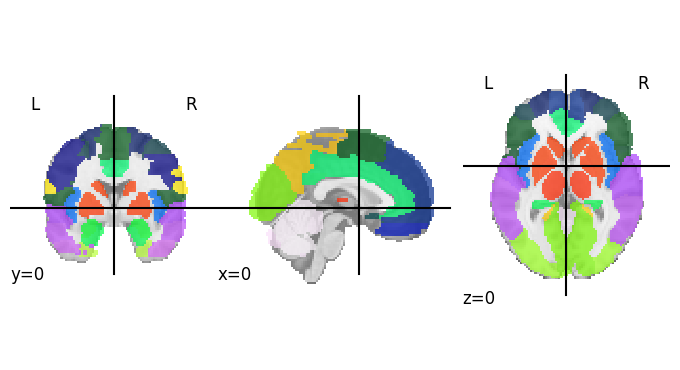

In [16]:
nilearn.plotting.plot_roi(atlas_img, cut_coords=(0,0,0))

## Data transformation and ROI extraction

In fMRI analysis it is often useful to transform the raw 3D/4D brain images into a 2D **samples × features** matrix.  
- For a 4D fMRI file, each row represents a time point (sample), and each column represents a feature (e.g., voxel intensity, ROI signal, or network average).  
- For a 3D image, the transformation results in a single row (1 × features), corresponding to spatial features only.

This transformation allows us to apply statistical and machine learning methods, which expect data in a tabular format. The **masker** objects in Nilearn act as “Swiss-army knives”: they cut, reshape, filter, and aggregate raw neuroimaging data into the units of observation most relevant to the research question.



### Defining a `NiftiLabelsMasker`

One of the most common maskers is the `NiftiLabelsMasker`. It extracts the mean time series from each region of interest (ROI) defined by an atlas. In our case, we use the **AAL atlas**.  

Key preprocessing options:  
- `standardize=True` → z-score each ROI time series so they have mean 0 and variance 1.  
- `detrend=True` → remove slow linear drifts over time.  
- `high_pass=0.009`, `low_pass=0.08` → retain only the canonical *resting-state frequency band* (0.009–0.08 Hz).  
- `resampling_target='labels'` → resample the fMRI data into the space of the atlas labels.  
- `t_r=2` → specify the repetition time of the COBRE dataset (2 seconds per volume).  

These steps ensure that the extracted ROI signals are directly comparable across regions and subjects, and that they are properly filtered for connectivity analysis.

In [17]:
masker = NiftiLabelsMasker(labels_img=aal_atlas.maps, background_label=0, 
                               standardize=True, detrend=True, resampling_target='labels', 
                               low_pass=0.08, high_pass=0.009,t_r=2, memory='nilearn_cache', memory_level=1, verbose=0)
        

### Extract ROI time series

1. Concatenate the 4D image (safe step in case multiple runs are used).  
2. Load confounds (motion, white matter, CSF, global signal).  
3. Apply the masker to extract **time series for each ROI**.  

The output is a 2D array: `n_timepoints × n_ROIs`.  
Each column = average BOLD signal for one region of interest.

In [18]:
img = concat_imgs(fmri_filename, auto_resample=True, verbose=0)
# confounds = high_variance_confounds(img, 1)
confounds, mask =load_confounds_strategy(fmri_filename)
time_series = masker.fit_transform(img, confounds)

<details>
<summary><strong>Reflection: Why regress out confounds?</strong></summary>

👉 When extracting ROI time series from 4D fMRI data, many fluctuations are present that do not reflect neural activity.  
To improve the quality of functional connectivity, several sources of spurious variance are removed through linear regression:  

1. **Head motion** (6 rigid-body parameters + derivatives).  
2. **Global signal** (average over the whole brain, often reflecting physiological or scanner noise).  
3. **Ventricular signal** (from cerebrospinal fluid regions, not related to neural activity).  
4. **White matter signal** (from WM regions, also not primarily neural).  

This regression procedure reduces the influence of head movements, physiological noise (e.g., breathing, heartbeat), and scanner artifacts.  
As a result, the remaining ROI time series are “cleaner,” and the correlations between them are more likely to reflect true neural interactions rather than synchronized noise.  
</details>

### Build a functional connectivity matrix

We compute pairwise correlations (Pearson by default) between ROI time series.  

The result is an ROI × ROI correlation matrix, where each entry shows how strongly two regions co-fluctuate over time.  
- Diagonal = 1 (self-correlation).  
- Positive values = synchronous activity.  
- Negative values = anti-correlated regions.  

We then visualize the matrix:  
- `reorder=True` clusters similar regions together.  
- Color scale highlights strong positive (red) and negative (blue) correlations.

In [19]:
correlation_measure = ConnectivityMeasure(kind="correlation")
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

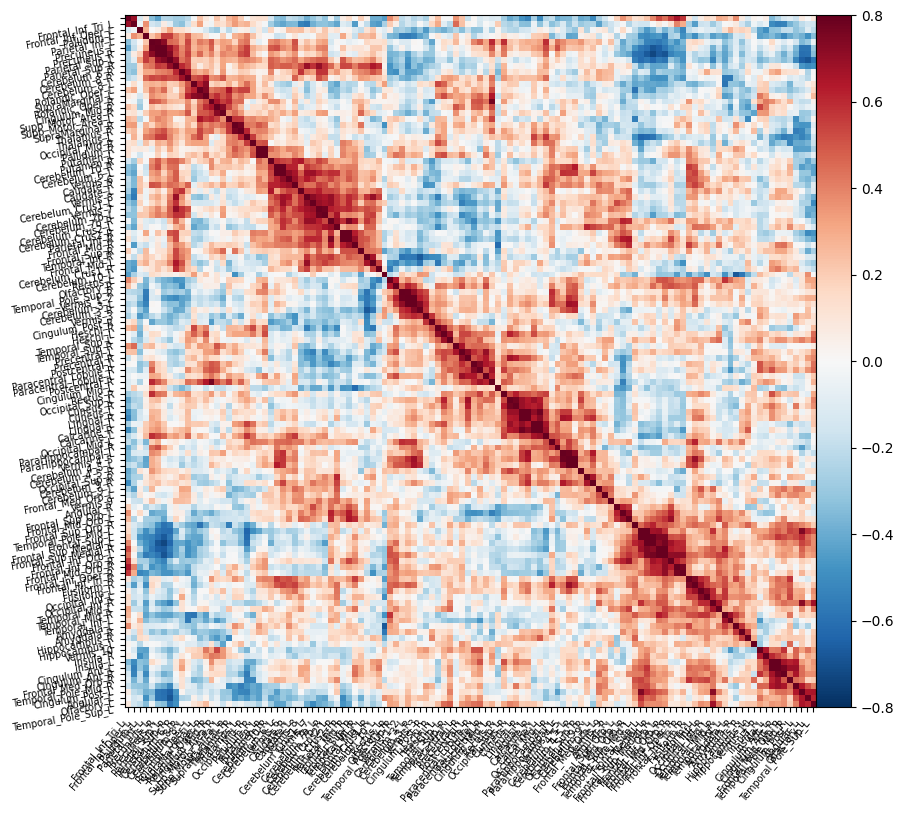

In [20]:
plotting.plot_matrix(
    correlation_matrix,
    figure=(10, 8),
    labels=aal_atlas.labels[:],
    vmax=0.8,
    vmin=-0.8,
    reorder=True,
)

<details>
<summary><strong>Reflection: Why not use a full band-pass filter?</strong></summary>

👉 Two filtering strategies were considered: applying a full band-pass filter (0.009–0.08 Hz) versus using only a high-pass filter at 0.009 Hz.  
It was observed that band-pass filtering tended to introduce a large number of spurious correlations.  
As a result, the pipeline was configured with only a high-pass cutoff at 0.009 Hz, which removes slow drifts and very low-frequency trends while preserving higher-frequency fluctuations.  
</details>

In [21]:
masker = NiftiLabelsMasker(labels_img=aal_atlas.maps, background_label=0, 
                               standardize=True, detrend=True, resampling_target='labels', 
                               high_pass=0.009, t_r=2, memory='nilearn_cache', memory_level=1, verbose=0)
        

In [26]:
confounds_simple, mask =load_confounds_strategy(fmri_filename)
time_series = masker.fit_transform(img, confounds_simple)

In [27]:
correlation_measure = ConnectivityMeasure(kind="correlation")
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

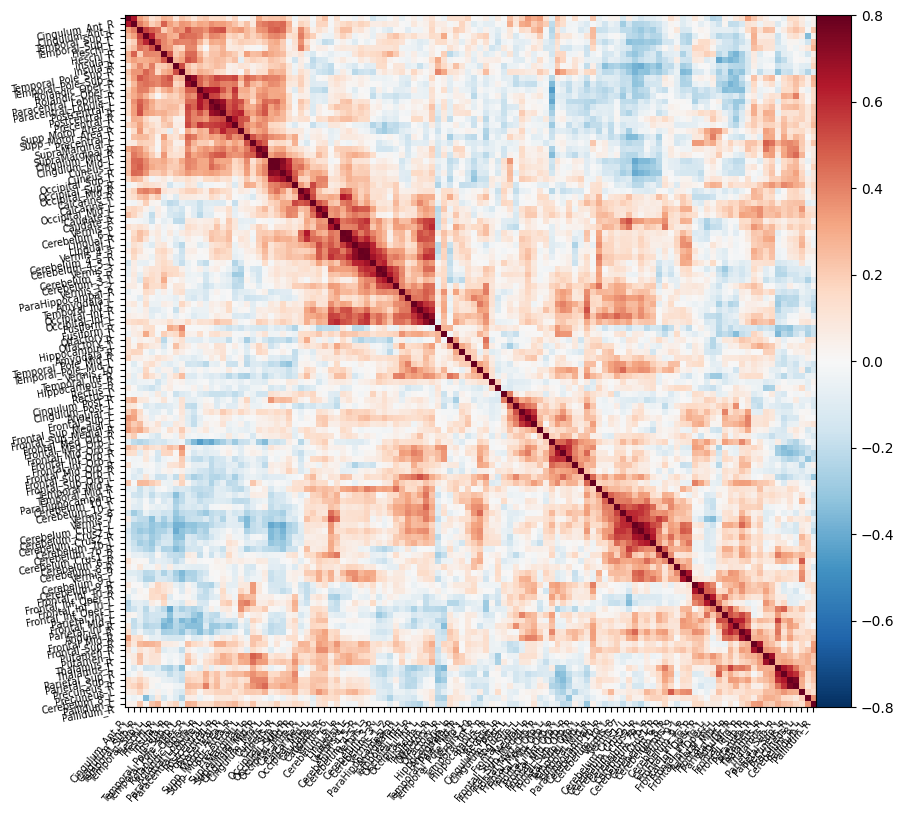

In [28]:
plotting.plot_matrix(
    correlation_matrix,
    figure=(10, 8),
    labels=aal_atlas.labels[:],
    vmax=0.8,
    vmin=-0.8,
    reorder=True,
)

Before we build connectivity matrices, we must ensure that the raw ROI time series 
are comparable across regions and subjects.  

- fMRI signals contain **artifacts**: scanner drift, subject motion, physiological noise.  
- Even small drifts or shifts can artificially inflate or suppress correlations.  
- Standard practice in neuroimaging:  
  - **Detrend** the signal (remove linear drifts).  
  - **Standardize** (z-score) each time series so that all have mean ≈ 0 and std ≈ 1.  

This ensures that correlations later reflect **true neural synchrony** rather than 
trivial differences in amplitude or baseline.

In [29]:
def make_correlation_matrix(path_to_fmriprep_data, output_path, path_to_save_connectivity_matrices=False):
    """
        Process the fmriprep preprocessed functional MRI time-series into 2D correlation matrix as DataFrame using Nilearn lib.
    """
    dataset = datasets.fetch_atlas_aal(version='SPM12', data_dir=None, url=None, resume=True, verbose=1)
    atlas_filename = dataset.maps
    labels = dataset.labels
    time_series,correlation_matrix = None, None
    correlation_measure = ConnectivityMeasure(kind='correlation')
    ts =  []
    for n_patient, patient_folder_name in enumerate(glob.glob(path_to_fmriprep_data+"/sub-*/")[:]):
            try:
                patient_folder_name =Path(patient_folder_name).name
                print(n_patient, patient_folder_name)
                temp_path = os.path.join(path_to_fmriprep_data, patient_folder_name)
                print(temp_path)
                   # temp_path = path_to_fmriprep_data + patient_folder_name + '/func/'
                filename = os.path.join(temp_path+ '/func' , f"{patient_folder_name}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
                # tr = tr_extractor(os.path.join(temp_path, 'ses-1/func', filename))
                print(filename)
                # print(tr)
                tr = 2
                # extracted data from non-overlapping volumes
                masker = NiftiLabelsMasker(labels_img=atlas_filename, background_label=0, 
                                       standardize=True, detrend=True, resampling_target='labels', 
                                        low_pass=0.1, high_pass=0.009,t_r=2,
                                         memory='nilearn_cache', 
                                        memory_level=1, verbose=0)

                confounds, mask =load_confounds_strategy(filename)
                time_series = masker.fit_transform(filename, confounds)
                print(time_series.shape)
                ts.append(time_series)
                correlation_matrix = correlation_measure.fit_transform([time_series])[0]
                np.fill_diagonal(correlation_matrix, 1)

                data =pd.DataFrame(correlation_matrix, columns=labels, index =labels)
                corr_dict ={}
                for i, column in enumerate(data.columns):
                    for j in data.columns[:i]:
                        corr_value =data.loc[j,column]
                        corr_dict[f'{j}-{column}'] =corr_value
                pd.DataFrame(time_series,columns=labels).to_csv(f"{output_path}/{patient_folder_name}_embed.csv", index= False)
                data.to_csv(f"{output_path}/{patient_folder_name}.csv")
            except Exception as e:
                print(e)
    return ts, time_series, correlation_matrix    

In [33]:
path_to_dataset ='./COBRE'
from pathlib import Path

output_path = Path('./COBRE/cobre_low0.1/')

# Создаём директорию и все промежуточные папки
output_path.mkdir(parents=True, exist_ok=True)

In [34]:
# load ABIDE1 data from NYU site
ts, time_series, correlation_matrix = make_correlation_matrix(path_to_dataset, output_path)

0 sub-A00000368
./COBRE/sub-A00000368
./COBRE/sub-A00000368/func/sub-A00000368_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(150, 116)
1 sub-A00000456
./COBRE/sub-A00000456
./COBRE/sub-A00000456/func/sub-A00000456_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(150, 116)
2 sub-A00000838
./COBRE/sub-A00000838
./COBRE/sub-A00000838/func/sub-A00000838_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(150, 116)
3 sub-A00000541
./COBRE/sub-A00000541
./COBRE/sub-A00000541/func/sub-A00000541_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(150, 116)


In [35]:
ts

[array([[ 0.2961825 , -0.03980765,  0.01494201, ..., -0.50055286,
         -0.4656493 , -0.32174199],
        [-0.77794896, -0.84798813,  0.90872149, ..., -0.49539036,
         -0.44169206, -0.45545246],
        [-0.25353391, -0.15625493,  0.68269539, ..., -0.20749122,
         -0.00238518,  0.10680342],
        ...,
        [-0.76062895, -1.01314682,  0.48581893, ..., -0.59043158,
         -0.55410552, -0.22112101],
        [-0.34132423, -0.51239535,  0.30674622, ..., -0.02913051,
         -0.1618594 ,  0.21848113],
        [ 0.0409849 ,  0.29212125, -0.29024526, ...,  0.1934047 ,
          0.02900714,  0.61424183]]),
 array([[-0.3587094 , -0.43055456,  0.11909318, ..., -0.03020138,
         -0.05032838, -0.10407134],
        [-0.37068182, -0.94215662,  0.45157727, ...,  0.18728613,
          0.63549065,  0.06674307],
        [ 0.26752562, -0.80152388,  0.62396157, ...,  0.50524909,
          1.16390992,  0.42491031],
        ...,
        [ 0.66726326,  0.79154102, -0.83359483, ...,  

In [36]:
ts = np.stack(ts)
(n_patients, n_steps, n_regions) = ts.shape

In [37]:
n_patients, n_steps, n_regions

(4, 150, 116)

### Multivariate time-series

#### Visualization of time series

We first plot a few ROI signals from one subject.  
They already look oscillatory, but we want to check:  
- Are they centered around zero?  
- Do they have similar scale?  

If not, correlations will be misleading.

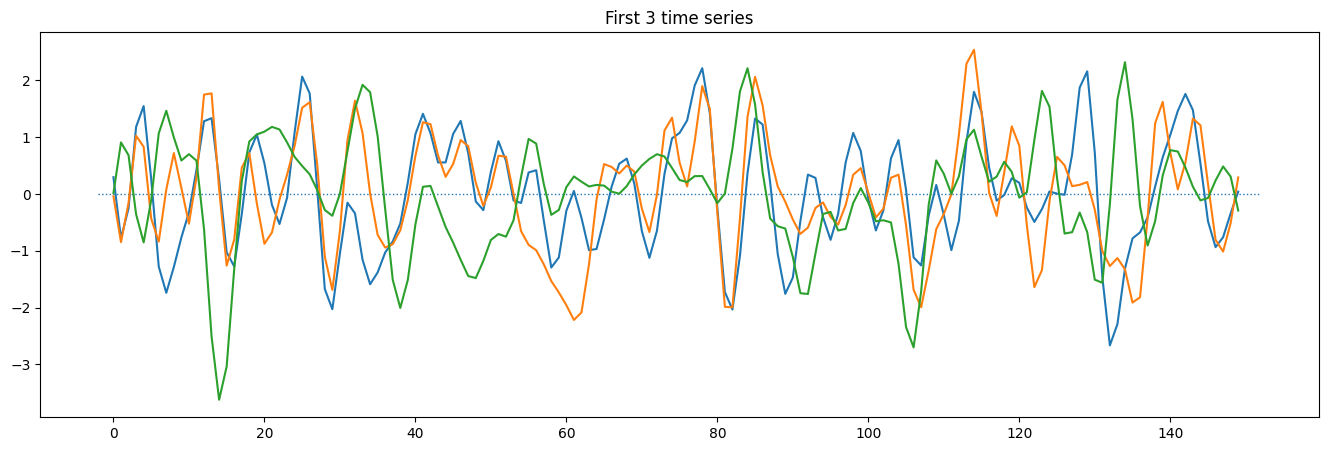

In [38]:
# visualization of raw time series
plt.figure(figsize=(16.5,5))
plt.title("First 3 time series")
plt.hlines(0, -2, n_steps+2, linewidth=1.0, linestyles="dotted")
plt.plot(ts[0,:,:3])
plt.show()

In [39]:
# mean and standard deviation
print("Mean ± std of the:")
print("1st time series: {:.3f} ± {:.3f}".format(np.mean(ts[0,:,0]), np.std(ts[0,:,0])))
print("2nd time series: {:.3f} ± {:.3f}".format(np.mean(ts[0,:,1]), np.std(ts[0,:,1])))
print("3rd time series: {:.3f} ± {:.3f}".format(np.mean(ts[0,:,2]), np.std(ts[0,:,2])))

Mean ± std of the:
1st time series: 0.000 ± 1.000
2nd time series: 0.000 ± 1.000
3rd time series: 0.000 ± 1.000


#### Normalization and trend removal

To understand why preprocessing is necessary, we **intentionally distort** two of the signals:  
- Add a large constant offset (shift upwards).  
- Add a linear trend (slow drift).  

This mimics what can happen in real data due to scanner instabilities or 
physiological noise.

Notice how the mean and standard deviation are now far from 0 and 1.

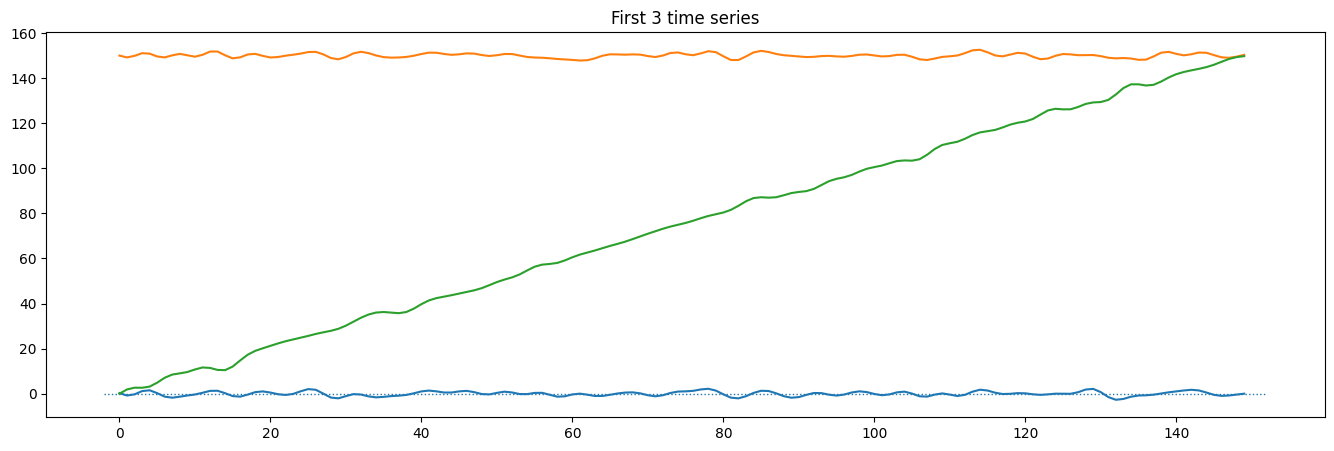

In [42]:
# visualization of broken time series
plt.figure(figsize=(16.5,5))
plt.title("First 3 time series")
plt.hlines(0, -2, n_steps+2, linewidth=1.0, linestyles="dotted")
plt.plot(ts[0,:,:3])
plt.show()

In [ ]:
# mean and standard deviation
print("Mean ± std of the:")
print("1st time series: {:.3f} ± {:.3f}".format(np.mean(ts[0,:,0]), np.std(ts[0,:,0])))
print("2nd time series: {:.3f} ± {:.3f}".format(np.mean(ts[0,:,1]), np.std(ts[0,:,1])))
print("3rd time series: {:.3f} ± {:.3f}".format(np.mean(ts[0,:,2]), np.std(ts[0,:,2])))

<details>
<summary><strong>Reflection: Why this matters (nuance)?</strong></summary>

- Offset by itself does not change the **Pearson correlation coefficient** (since it is computed on centered data), but its presence indicates that preprocessing was incomplete.  
- **Drift** introduces low-frequency shared variability, which can artificially inflate correlations between ROIs and distort network metrics.  

👉 Therefore, before computing functional connectivity, at minimum we apply **detrending + standardization** (and, in most pipelines, **confound regression** and **filtering**).  
</details>

We now apply `nilearn.signal.clean` to each subject's ROI time series.

Options used:
- `detrend=True` → removes linear drifts.
- `standardize="zscore"` → rescales each series to mean=0, std=1.

This procedure **removes the artificial offset and trend** we introduced.  
It also prepares the data for valid correlation analysis.

In [43]:
from nilearn.signal import clean

In [44]:
ts_normalized = np.zeros_like(ts)

# normalize and detrend
for i in range(ts.shape[0]):
    ts_normalized[i] = clean(ts[i], standardize="zscore", detrend=True)
    
print("Mean ± std of the:")
print("1st time series: {:.3f} ± {:.3f}".format(np.mean(ts_normalized[0,:,0]), np.std(ts_normalized[0,:,0])))
print("2nd time series: {:.3f} ± {:.3f}".format(np.mean(ts_normalized[0,:,1]), np.std(ts_normalized[0,:,1])))
print("3rd time series: {:.3f} ± {:.3f}".format(np.mean(ts_normalized[0,:,2]), np.std(ts_normalized[0,:,2])))

Mean ± std of the:
1st time series: 0.000 ± 1.000
2nd time series: 0.000 ± 1.000
3rd time series: -0.000 ± 1.000


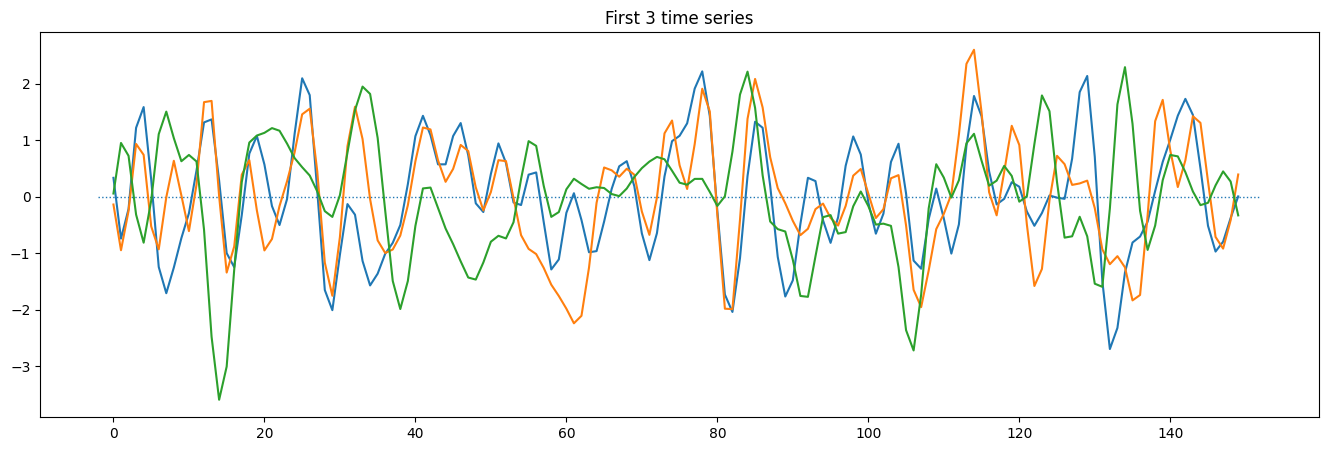

In [45]:
# visualization of raw time series
plt.figure(figsize=(16.5,5))
plt.title("First 3 time series")
plt.hlines(0, -2, n_steps+2, linewidth=1.0, linestyles="dotted")
plt.plot(ts_normalized[0,:,:3])
plt.show()

From now on, all connectivity analyses (correlation matrices, graph features, ML pipeline) 
should be based on the **cleaned version** of the time series.

This step is critical: without it, the functional connectivity (FC) network 
would be dominated by scanner artifacts rather than neural activity.

In [46]:
ts = ts_normalized

## Metrics of Functional Connectivity — Why Compare Several?

**Goal.** Different metrics capture different types of dependencies:  
- **Pearson** — linear relationships (most common baseline).  
- **Spearman** — monotonic relationships, robust to outliers (rank-based).  
- **Mutual Information (MI)** — detects **non-linear** dependencies.  

By comparing them, we obtain a more robust picture of brain networks and avoid bias from assuming only linear effects.


### Pearson correlation

## Pearson Correlation with an Explicit Covariance Estimator

**What is happening here?**

Normally, when we compute Pearson correlation, we take pairwise correlations of ROI time series.  

However, under the hood this requires computing a **covariance matrix**, and the choice of covariance estimator matters. 
The covariance matrix of a data set is known to be well approximated  with the classical maximum likelihood estimator (or “empirical covariance”),  provided the number of observations is large enough compared to the number of features  (the variables describing the observations). More precisely, the Maximum Likelihood Estimator of a sample is an unbiased estimator of the corresponding population covariance matrix.

- By default, `ConnectivityMeasure(kind="correlation")` uses the **sample covariance** (Maximum Likelihood Estimator).  
- Here we explicitly pass `EmpiricalCovariance()` from scikit-learn, which implements the same MLE but makes the step more transparent and extendable (later we can replace it with shrinkage or robust estimators).


In [69]:
from nilearn.connectome import ConnectivityMeasure
from sklearn.covariance import EmpiricalCovariance

covariance_estimator = EmpiricalCovariance()
connectivity_correlation = ConnectivityMeasure(kind="correlation", cov_estimator=covariance_estimator)

In [70]:
ts[0].shape

(150, 116)

In [71]:
R = connectivity_correlation.fit_transform(ts)
R.shape

(163, 116, 116)

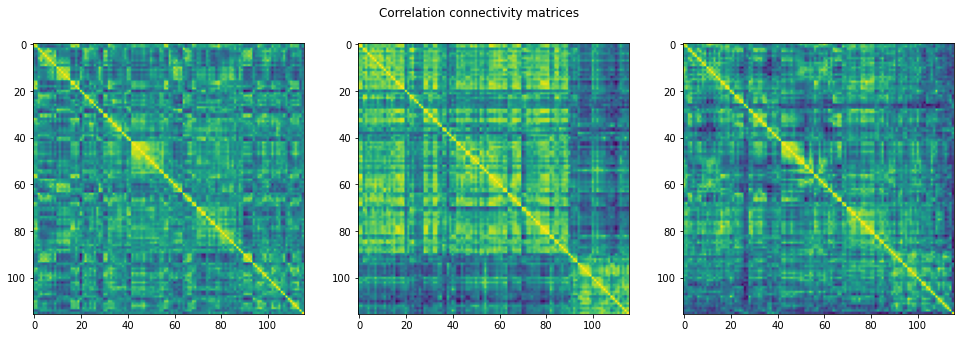

In [72]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.5,5))
plt.suptitle("Correlation connectivity matrices")
ax1.imshow(R[0])
ax2.imshow(R[1])
ax3.imshow(R[2])
plt.show()

<details>
<summary><strong>Reflection: How to read connectivity matrices?</strong></summary>

👉 Functional connectivity matrices are symmetric (ROI × ROI), with correlation values between -1 and 1.  

- **Diagonal (bright yellow)** → self-correlation = 1.  
- **Off-diagonal blocks** → clusters of ROIs with higher correlations, often corresponding to functional networks (e.g., Visual, Motor, Default Mode Network).  
- **Darker areas** → weak or negative correlations, reflecting little or anti-correlated activity between regions.  

These patterns allow us to visually identify large-scale brain networks and compare them across subjects or conditions.  
</details>

**Why this matters:**

- Pearson correlation is the baseline metric of functional connectivity.
- By explicitly setting the covariance estimator, we make the pipeline more flexible and ready to compare with regularized or robust estimators later.

## Regularization: Why and How

**Problem.**  
When the number of time points (T) is not much larger than the number of ROIs (N), the sample covariance (and derived correlation) matrices often become **ill-conditioned**.  

- Some eigenvalues may be extremely small or even negative (due to noise or numerical error).  
- Such matrices are nearly singular, making them unstable to invert.  
- This is especially problematic if we want to compute **precision matrices** (inverse covariance), which are used in partial correlation analysis or graphical models.  

**Task**  
The **condition number** of a matrix is defined as the ratio between its largest and smallest eigenvalue.  
- If the smallest eigenvalue is very close to zero (or even negative), the matrix becomes **ill-conditioned**.  
- Ill-conditioned matrices are unstable to invert and can lead to unreliable estimates when computing **precision matrices**

In [73]:
np.min(np.linalg.eigvalsh(R[0]))

-1.4636389459456035e-15

Often close to 0 or slightly negative → instability.

#### Tikhonov regularization (ridge / diagonal loading)

To stabilize the covariance or correlation matrix, we can apply **Tikhonov regularization**, also known as ridge correction:  

$$\tilde{\mathbf{C}}_X = \mathbf{C}_X + \alpha \mathbf{I},~~~\alpha > 0$$

This has two key effects:  
1. It shifts **all eigenvalues** upward by \(\alpha\).  
2. It guarantees that the matrix becomes positive definite, improving its condition number.  

**Goal.**  
Apply Tikhonov regularization to a correlation matrix and check:  
- how the **minimum eigenvalue** changes before and after,  
- how this improves the **condition number**.

In [74]:
### your code here

alpha = 0.01
R_regularized = R[0] + alpha * np.eye(n_regions)

Adds αI, shifting eigenvalues upward, guaranteeing positive definiteness.

### Shrinkage Estimators: Why We Need Them

**Problem.**  
The **Maximum Likelihood Estimator (MLE)** of covariance is unbiased for the covariance itself, but it is **not a good estimator of eigenvalues** when the dimensionality is high and the number of samples is small.  
- Eigenvalues are often badly estimated: some become too small, some too large.  
- This causes the inverted matrix (precision matrix) to be inaccurate or unstable.  
- In extreme cases, the empirical covariance matrix is not even invertible due to numerical reasons.  

**Idea. Shrinkage.**  
To fix this, shrinkage estimators combine the empirical covariance with a well-behaved target matrix (usually the identity).  
This stabilizes eigenvalues and guarantees invertibility.

#### Ledoit–Wolf Shrinkage

$$
\tilde{\mathbf{C}}_X = (1 - \beta)\mathbf{C}_X + \alpha \beta \mathbf{I}, 
\quad \alpha > 0, \quad 0 \leq \beta \leq 1 \\
\alpha = \frac{\text{trace}(\mathbf{C})}{n_{\text{features}}}
$$

- $\mathbf{C}_X$ = empirical covariance matrix.  
- $\alpha I$ = scaled identity matrix (well-conditioned target).  
- $\beta$ = shrinkage coefficient, automatically estimated from the data.  

**Intuition.**  
- If $\beta = 0$: we get pure empirical covariance (unstable, ill-conditioned).  
- If $\beta = 1$: we get a multiple of the identity (too simplistic, discards structure).  
- Ledoit–Wolf finds the **optimal balance** between the two.  

**Why it matters.**  
- Produces covariance matrices that are always invertible.  
- Improves estimation of eigenvalues (and thus condition number).  
- Leads to more reliable **precision matrices**, which are essential for partial correlation networks and graphical models.  

👉 Shrinkage is widely used in high-dimensional fMRI connectivity analysis because the number of ROIs (features) is often comparable to or larger than the number of time points (samples).


In [75]:
from sklearn.covariance import LedoitWolf

# Initialize Ledoit–Wolf shrinkage covariance estimator
cov_estimator_shrinked = LedoitWolf()
# Wrap it into a ConnectivityMeasure object
connectivity_correlation_shrinked = ConnectivityMeasure(kind="correlation", cov_estimator=cov_estimator_shrinked)

In [76]:
# Fit to one subject and check the estimated shrinkage parameter β# check the value of beta parameter
cov = cov_estimator_shrinked.fit(ts[0])
cov.shrinkage_ # The .shrinkage_ attribute is the estimated shrinkage coefficient β:

0.08400939635656181

~0.08 means ~8% of the weight comes from the identity matrix (scaled target), and ~92% from empirical covariance.

In [77]:
# Compute shrinkage-based correlation matrices for all subjects
R_shrinked = connectivity_correlation_shrinked.fit_transform(ts)

In [78]:
# Check the minimum eigenvalue (should now be strictly positive)
np.min(np.linalg.eigvalsh(R_shrinked[0]))

0.08400939635656045

~0.084 > 0

Interpretation.
- Positive minimum eigenvalue → matrix is now stable and invertible.
- This is crucial before computing graph/spectral features or precision matrices.

### Spearman Correlation (Rank-Based)

**Why we do this.**  
Pearson captures linear relationships, but Spearman measures **monotonic** dependencies.  
It is more robust to outliers and nonlinear scaling of signals, which is often useful in noisy fMRI data.


In [79]:
from scipy.stats import spearmanr

In [80]:
S = np.zeros((3, n_regions, n_regions))

for i in range(3):
    S[i], _ = spearmanr(ts[i])

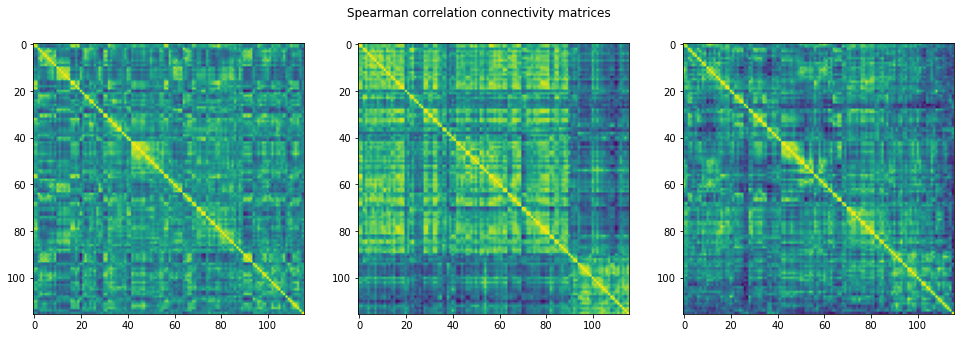

In [81]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.5,5))
plt.suptitle("Spearman correlation connectivity matrices")
ax1.imshow(S[0])
ax2.imshow(S[1])
ax3.imshow(S[2])
plt.show()

<details>
<summary><strong>Reflection: How to read connectivity matrices?</strong></summary>

👉 Similar block structures to Pearson, but less sensitive to outliers and nonlinear scaling.  
</details>


### Mutual Information (MI): Capturing Non-Linear Dependence

### Why Pearson and Spearman may not be enough
- **Pearson correlation** only measures *linear* dependence between two signals.  
- **Spearman correlation** detects *monotonic* dependence (e.g., one increases when the other increases), but still assumes a specific type of relationship.  
- But brain signals can interact in **non-linear ways** (e.g., saturation, thresholds, oscillatory coupling).  

👉 To capture such interactions, we use **Mutual Information (MI)**.

Mutual information measures the information that random variables $X$ and $Y$ share, how much knowing one of these variables reduces uncertainty about the other. determined how different to joint distributon $p(X, Y)$ is to the production of the marginal distrubutions $p(X) p(Y)$: $$I(X, Y) = \sum_{(x, y)} p(x, y) \log_2 \left( \frac{p(x, y)}{p(x)p(y)} \right)$$


#### What MI tells us
- MI quantifies how much knowing the time series of region X reduces uncertainty about region Y.  
- Unlike correlation, MI = 0 only if X and Y are **independent** (no information shared).  
- Higher MI → stronger dependence (linear or non-linear).  



### Quick visual check of an ROI pair

**Why.** Before computing MI, it’s useful to look at the **shape of the dependence** between two ROIs:  
- Elliptical cloud → mostly linear dependence (Pearson is fine).  
- Curved / clustered cloud → possible **non-linear** dependence (MI is more appropriate).  


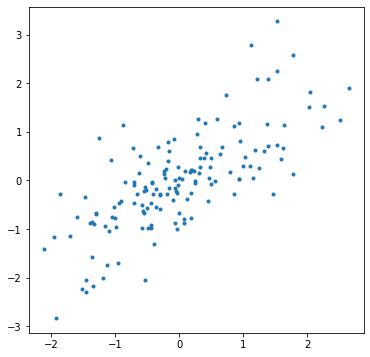

In [82]:
plt.figure(figsize=(6,6))
plt.plot(ts[2,:,0], ts[2,:,12], ".")

Here, ts has shape (subjects, timepoints, n_ROIs). We take subject 2, comparing ROI 0 vs ROI 12.

<details>
<summary><strong>Reflection: How to read the plot?</strong></summary>

👉 If the scatter is not purely elliptical (or deviates strongly from a straight line), **Pearson** may underestimate the relationship — **Mutual Information (MI)** can capture it.  
</details>

###  Functions: estimating MI and normalizing to [0,1]

**Why.** Raw MI (in nats/bits) is unbounded and not directly comparable with correlation.  It’s convenient to map it to a **correlation-like index in [0,1]**.


In [83]:
from sklearn.metrics import mutual_info_score

# calc_MI computes MI via a 2D histogram
def calc_MI(x, y, bins=10):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi
# bound maps MI to ρ_MI ∈ [0,1], making it easier to compare with correlations
def bound(x):
    return np.sqrt(1 - np.exp(-2 * x))

In [84]:
l = calc_MI(ts[1,:,42], ts[1,:,45])
l, bound(l)

(0.5400360896325161, 0.812667819730738)

<details>
<summary><strong>Reflection: How to read</strong></summary>

👉 If ρ<sub>MI</sub> is noticeably above 0 (e.g., 0.3–0.8), the regions share dependence — possibly non-linear.  
</details>

### 2D histogram as a visual “fingerprint”

**Why.** Helps verify that MI isn’t just noise. 

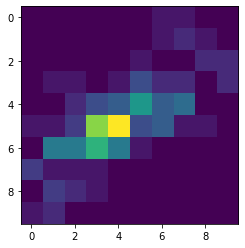

In [85]:
c_xy = np.rot90(np.histogram2d(ts[2,:,0], ts[2,:,12], 10)[0])
plt.imshow(c_xy)

<details>
<summary><strong>Reflection: How to read</strong></summary>

👉 Bright squares = regions where the joint distribution is dense.  
A structured pattern (not uniform) → stronger **Mutual Information (MI)**.  
</details>

In [86]:
l = calc_MI(ts[1,:,42], ts[1,:,41])
l, bound(l)

(0.2519739291152246, 0.6291733600452909)

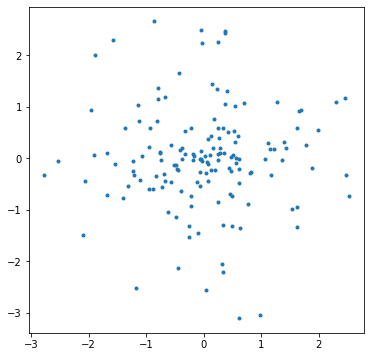

In [87]:
plt.figure(figsize=(6,6))
plt.plot(ts[2,:,42], ts[2,:,41], ".")

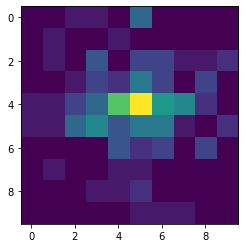

In [88]:
c_xy = np.rot90(np.histogram2d(ts[2,:,42], ts[2,:,41], 10)[0])
plt.imshow(c_xy)

### Full MI-based connectivity matrix

**Why.** Build a full **connectivity matrix based on MI**, analogous to Pearson but capturing non-linear dependencies.


In [89]:
%%time
M = np.zeros((3, n_regions, n_regions))

for k in range(3):
    for i in range(n_regions):
        for j in range(i, n_regions):
            M[k,i,j] = bound(calc_MI(ts[k,:,i], ts[k,:,j]))
            
    M[k] = M[k] + M[k].T
    np.fill_diagonal(M[k], 1)

CPU times: user 11 s, sys: 67 µs, total: 11 s
Wall time: 11 s


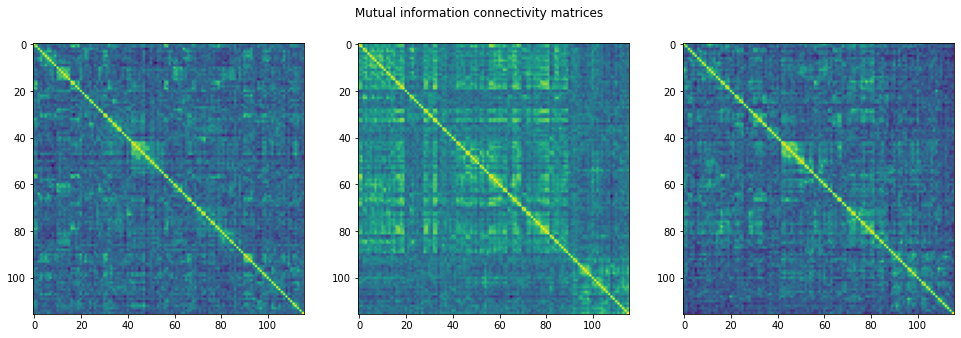

In [90]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.5,5))
plt.suptitle("Mutual information connectivity matrices")
ax1.imshow(M[0])
ax2.imshow(M[1])
ax3.imshow(M[2])
plt.show()

- Triple loop computes ρ_MI for each ROI pair.
- Symmetrization ensures the matrix is undirected.
- Diagonal is set to 1 (self-dependence).

### Thresholding

**Why.** The full FC (functional connectivity) matrix is dense (an edge between every pair of ROIs), which:  
- makes interpretation and visualization difficult,  
- includes weak or noisy connections.  

Thresholding makes the matrix **sparse**, keeping only the “strong” edges.

In [91]:
R_tresholded = R[0].copy()
np.fill_diagonal(R_tresholded, 0)
R_tresholded[R_tresholded < 0.5] = 0.0
R_tresholded

array([[0.        , 0.74564723, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.74564723, 0.        , 0.        , ..., 0.51606778, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.51606778, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

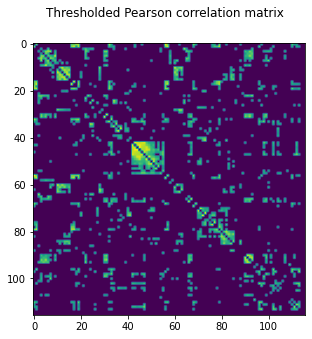

In [92]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
plt.suptitle("Thresholded Pearson correlation matrix")
ax1.imshow(R_tresholded)
plt.show()

<details>
<summary><strong>Reflection: Useful thresholding strategies</strong></summary>

👉 Different ways exist to make functional connectivity matrices sparse and comparable:  

- **By absolute value**:  
  <code>R_thr = np.where(np.abs(R[0]) >= 0.5, R[0], 0)</code>  
  → keeps both strong positive and strong negative connections.  

- **By density (recommended for group comparisons)**:  
  Keep the **top-10% of strongest edges** → ensures all subjects have the same graph density.  

- **By significance (FDR / permutation)**:  
  Threshold edges using p-values from permutation tests or false discovery rate control.  
</details>

## From Connectivity Matrices to Graphs

Once we have constructed functional connectivity matrices (via Pearson, Spearman, shrinkage, or mutual information), we can interpret them as graphs:
- Nodes = brain regions (ROIs).
- Edges = functional connections (correlations or MI values).

Thresholding is often applied first, so that only the strongest connections remain. This avoids “fully connected” graphs where every node is linked to every other.


### Network visualization (in MNI space, Nilearn)

**Why.** To show edges on the *brain map*: understand geography of the network (interhemispheric vs intrahemispheric, clusters).


In [330]:
from nilearn import plotting

# get coordinates of brain regions
atlas_aal = nilearn.datasets.fetch_atlas_aal()
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_aal["maps"])

In [331]:
coordinates.shape

(116, 3)

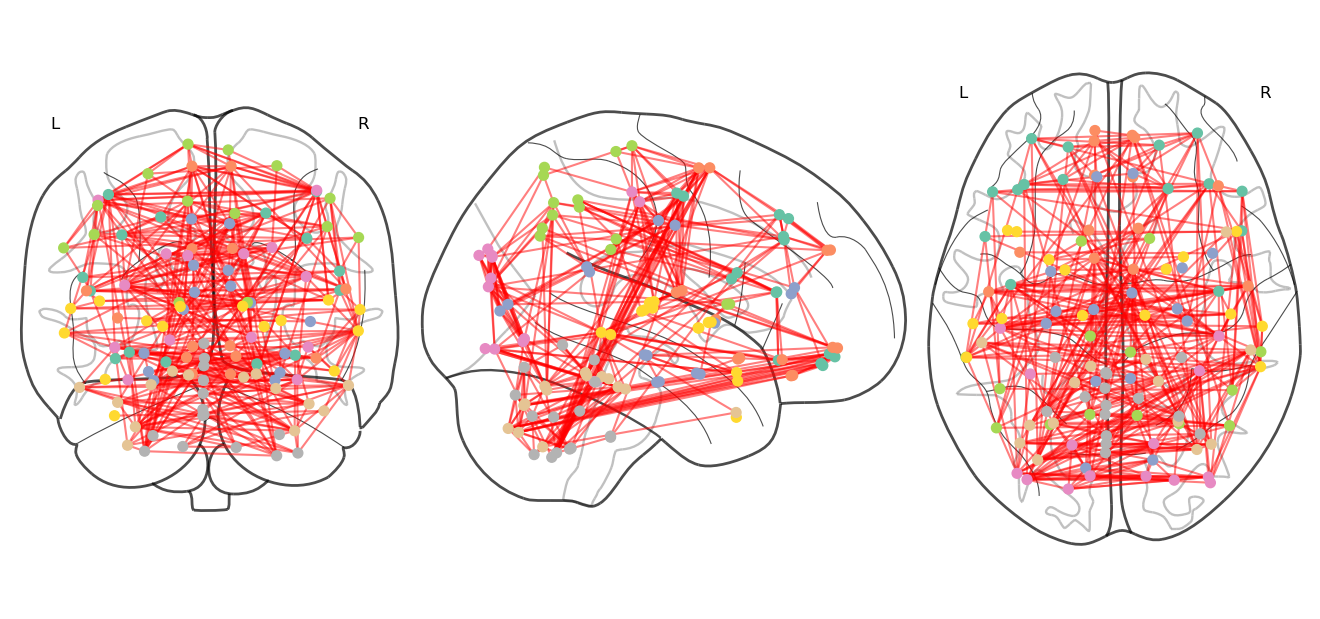

In [332]:
# nilearn graph drawing
fig = plt.figure(figsize=(13,6))
edge_options = {"color": "r", "linewidth": 1.5, "alpha": 0.5}
plotting.plot_connectome(R_tresholded, coordinates, figure=fig, edge_kwargs=edge_options)

**How it works.**

- find_parcellation_cut_coords computes MNI coordinates of each ROI center.
- plot_connectome draws nodes at those coordinates and edges wherever the matrix has nonzero weights.
- edge_kwargs sets visual style of edges.

**How to read the figure.**

- Three projections (coronal, sagittal, axial).
- Red lines = thresholded edges. You can see clusters (motor/visual cortex, interhemispheric links).

### Circular (shell) graph, NetworkX

**Why.** To give a **pure graph view** without anatomy — useful for comparing density, degree, and bridges.  


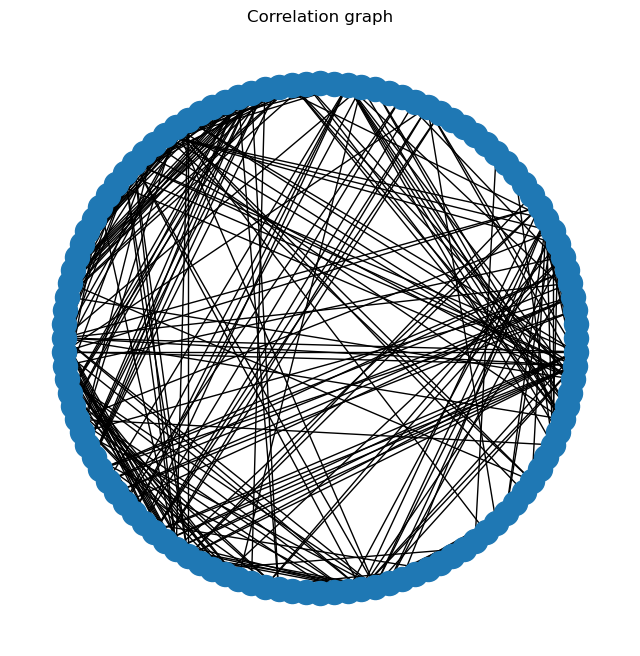

In [333]:
# matplotlib graph drawing
fig, (ax1) = plt.subplots(1, 1, figsize=(8,8))
ax1.set_title("Correlation graph")
nx.draw_shell(nx.from_numpy_array(R_tresholded), ax=ax1)
plt.show()

## Graph-Theoretic Network Analysis

Now we can use NetworkX to extract features of brain networks. These graph measures are widely used in network neuroscience.


In [93]:
# create graph from connectivity matrix
G_R = nx.from_numpy_array(R_tresholded)

#### Node degree

How many neighbors each node (ROI) has.

- High-degree nodes may represent “hubs.”

- Degree distribution gives an overview of network integration.

In [94]:
degree = np.array([degree[1] for degree in nx.degree(G_R)])
degree

array([23, 21, 15, 24, 13, 17, 20, 20,  9, 13, 13, 16, 12, 15, 14, 15, 15,
       20, 17, 19,  6,  6, 17,  5, 13,  9,  7,  7, 13,  3, 20, 21, 21, 31,
       17,  9, 10,  9,  2, 12, 11,  7, 23, 24, 16, 16, 24, 31, 12, 14, 19,
       17, 10, 11, 11, 23, 15, 15,  7,  2, 13, 14, 10, 14,  7,  6, 27, 23,
       15,  6, 12, 14, 10, 12,  5, 11, 10, 13, 10, 26, 12, 12, 19, 11, 16,
       15,  4,  1, 13,  4, 21, 18, 17, 18,  2,  2, 18, 12, 22, 20,  9,  9,
       21,  8, 18,  8,  1, 12,  1,  2, 17, 15, 16, 17,  0,  0])

For each node, compute the mean degree of its neighbors.

This shows whether high-degree nodes tend to connect to other high-degree nodes (assortativity) or to low-degree nodes.

In [95]:
neighbor_degree_avg = np.array(list(nx.average_neighbor_degree(G_R).values()))
neighbor_degree_avg

array([17.13043478, 18.0952381 , 11.86666667, 15.875     , 18.46153846,
       17.47058824, 15.4       , 16.4       , 14.33333333, 18.23076923,
       13.38461538, 13.25      , 13.16666667, 13.66666667, 13.5       ,
       13.93333333, 18.4       , 17.        , 18.82352941, 17.94736842,
       11.66666667, 10.16666667, 17.        , 19.4       , 16.76923077,
       10.33333333, 15.14285714, 11.14285714, 12.15384615, 12.33333333,
       19.2       , 19.        , 19.19047619, 18.90322581, 18.17647059,
       16.77777778, 14.1       , 12.11111111, 11.5       , 12.58333333,
       11.09090909, 12.        , 20.43478261, 19.79166667, 20.4375    ,
       19.6875    , 18.70833333, 18.93548387, 19.        , 17.92857143,
       17.10526316, 16.47058824, 16.2       , 17.27272727, 17.36363636,
       17.60869565, 19.        , 18.26666667, 15.        ,  8.        ,
       13.69230769, 14.14285714, 13.8       , 13.28571429, 14.42857143,
       19.66666667, 18.18518519, 20.13043478, 18.53333333, 18.83

#### Centralities

Centralities identify influential nodes in the network.
They assign numbers or rankings to nodes corresponding to their network position.

Applications:
- Identifying the most influential person(s) in a social network.
- Detecting key infrastructure nodes in the Internet or urban networks.
- Tracing super-spreaders in epidemics.
- Highlighting hub regions in brain networks.

Centrality measures can be seen as a spectrum:
- From those based on walks of length one (e.g., degree centrality)
- To those based on infinite walks (e.g., eigenvector centrality).
- Others, such as betweenness centrality, emphasize nodes that act as bridges, occupying positions pivotal to connectivity.

Examples used here:
- Betweenness centrality: how often a node lies on shortest paths between other nodes.
- Closeness centrality: inverse of the average shortest-path distance to all other nodes.

The betweenness centrality for each vertex is the number of these shortest paths that pass through the vertex.

In [96]:
centrality_betweenness = np.array(list(nx.betweenness_centrality(G_R).values()))
centrality_betweenness

array([0.05796134, 0.00986212, 0.0210008 , 0.02273872, 0.00130186,
       0.00645202, 0.01566464, 0.06092953, 0.01777818, 0.00278093,
       0.00294335, 0.02508357, 0.00436124, 0.00491859, 0.00966763,
       0.00280797, 0.00332356, 0.01250068, 0.02552564, 0.00311471,
       0.00272209, 0.00854677, 0.00552158, 0.0001132 , 0.01973303,
       0.00726041, 0.00695435, 0.00444824, 0.0063439 , 0.        ,
       0.00990823, 0.02244893, 0.0295549 , 0.07639931, 0.02213236,
       0.00439124, 0.00809938, 0.00988452, 0.00063647, 0.01051768,
       0.02102623, 0.00377408, 0.01678817, 0.01748191, 0.00229988,
       0.00312341, 0.02537909, 0.04922081, 0.00034349, 0.00351842,
       0.04920042, 0.01293224, 0.00351167, 0.0008149 , 0.02683825,
       0.02655298, 0.00119216, 0.00239961, 0.00390466, 0.00016635,
       0.00913669, 0.01149381, 0.0180433 , 0.00743251, 0.00076427,
       0.00152504, 0.05504903, 0.01740704, 0.00142259, 0.00125349,
       0.01013006, 0.01861675, 0.00469553, 0.00960283, 0.00459

Closeness centrality is reverse of the sum of the length of the shortest paths between the node and all other nodes in the graph.

In [338]:
centrality_closeness = np.array(list(nx.closeness_centrality(G_R).values()))
centrality_closeness

array([0.32898024, 0.28271739, 0.28811963, 0.31196402, 0.24254575,
       0.25774805, 0.3025738 , 0.31743707, 0.27249869, 0.28009153,
       0.24451234, 0.29089892, 0.24584121, 0.29373235, 0.30771961,
       0.31089198, 0.26453089, 0.25774805, 0.32081406, 0.30056334,
       0.        , 0.1615528 , 0.27836789, 0.2741502 , 0.23745293,
       0.25701581, 0.23377149, 0.        , 0.00869565, 0.00869565,
       0.24517497, 0.29089892, 0.30156522, 0.337573  , 0.25997001,
       0.24854276, 0.1975318 , 0.24922745, 0.13749174, 0.16242292,
       0.19710145, 0.14180183, 0.31855481, 0.31632715, 0.31304348,
       0.29278176, 0.30056334, 0.32660493, 0.28360365, 0.29565217,
       0.36333159, 0.32660493, 0.34139459, 0.29565217, 0.26925466,
       0.35339674, 0.30564042, 0.28539295, 0.28996656, 0.25701581,
       0.2284585 , 0.29089892, 0.26687187, 0.25484385, 0.26453089,
       0.30667649, 0.32543009, 0.32778828, 0.277514  , 0.23197324,
       0.20561265, 0.26453089, 0.20655152, 0.16847219, 0.00869

#### Clustering coefficient

Measures local segregation: how close neighbors of a node are to forming a clique (fully connected subgraph).

High clustering = strong local communities.

In [98]:
clustering_coefficient_local = np.array(list(nx.clustering(G_R).values()))
clustering_coefficient_local

array([0.41106719, 0.56190476, 0.32380952, 0.48550725, 0.84615385,
       0.74264706, 0.54736842, 0.37368421, 0.44444444, 0.82051282,
       0.74358974, 0.54166667, 0.71212121, 0.65714286, 0.61538462,
       0.7047619 , 0.71428571, 0.52105263, 0.44852941, 0.6374269 ,
       0.4       , 0.13333333, 0.63970588, 0.8       , 0.35897436,
       0.44444444, 0.19047619, 0.57142857, 0.58974359, 1.        ,
       0.64210526, 0.55238095, 0.5       , 0.36344086, 0.38235294,
       0.47222222, 0.26666667, 0.30555556, 0.        , 0.36363636,
       0.30909091, 0.47619048, 0.49802372, 0.47826087, 0.725     ,
       0.71666667, 0.45652174, 0.3655914 , 0.90909091, 0.72527473,
       0.39181287, 0.53676471, 0.73333333, 0.83636364, 0.32727273,
       0.43478261, 0.75238095, 0.73333333, 0.57142857, 0.        ,
       0.67948718, 0.68131868, 0.55555556, 0.63736264, 0.71428571,
       0.66666667, 0.41880342, 0.47826087, 0.73333333, 0.66666667,
       0.42424242, 0.31868132, 0.53333333, 0.43939394, 0.3    

#### Efficiency

Quantifies how efficiently information is exchanged across the network.

- Local efficiency: reflects the resilience of local neighborhoods.

It is computed as the global efficiency of the subgraph induced by the neighbors of each node. Intuitively, it measures how well information is exchanged among neighbors if a given node is removed.

- Global efficiency: captures the integration across the whole brain (or network).

It is defined as the average efficiency of all pairs of nodes, where the efficiency of a pair is the multiplicative inverse of the shortest path distance between them.

Underlying idea: the more distant two nodes are in the network, the less efficient their communication will be.

In [151]:
nx.local_efficiency(G_R)

0.6457836501540629

In [152]:
nx.global_efficiency(G_R)

0.44330334832581714

## Spectral graph theory
So far, we have looked at local graph properties (degree, clustering coefficient, local efficiency) and global properties (global efficiency, centralities).
These measures tell us how nodes are connected and how information flows.

But there is another, more mathematical lens: instead of directly analyzing nodes or edges, we can study the spectrum of matrices that represent the graph.

- For a brain network, this can be the connectivity (adjacency) matrix or the graph Laplacian.

- The eigenvalues and eigenvectors of these matrices encode deep structural information about the network.

- For example, in physics and neuroscience, the spectrum can reveal network synchronization, modularity, or diffusion dynamics.
    
Eigenvalues of
- connectivity matrix
- Laplacian matrix

#### Spectrum

Solve for $\mathbf{\lambda}$ the eigenvalue problem, where $\mathbf{A}$ is the connectivity matrix

$$\mathbf{Av} = \mathbf{\lambda} \mathbf{v}$$

In [101]:
eigenvalues, _ = np.linalg.eigh(R[0])
eigenvalues

array([-1.80415517e-15, -1.39086347e-15, -1.32850970e-15, -1.13848243e-15,
       -1.06085122e-15, -9.96640545e-16, -6.14895055e-16, -4.75267135e-16,
       -4.54675287e-16, -3.09526131e-16, -1.39038289e-16, -1.69644447e-17,
       -1.49762129e-18,  1.72646713e-16,  1.98885517e-16,  3.54639433e-16,
        7.06483652e-16,  7.23171833e-16,  9.06666639e-16,  1.07336314e-15,
        1.30168264e-15,  1.76776689e-15,  1.84271254e-15,  2.03964354e-15,
        2.68639072e-15,  1.03228721e-14,  1.94790412e-14,  2.43856878e-14,
        1.09993261e-13,  1.90903805e-13,  2.90636326e-13,  7.47622810e-13,
        8.62185631e-13,  2.17854930e-12,  3.00161145e-12,  7.47381505e-12,
        1.13732939e-11,  3.78383222e-11,  5.66380898e-11,  9.85010308e-11,
        1.58920729e-10,  2.42948231e-10,  4.70845248e-10,  6.33067917e-10,
        1.51691128e-09,  2.12491613e-09,  2.89744542e-09,  4.48663119e-09,
        9.56917383e-09,  2.05972218e-08,  2.95160577e-08,  5.47994791e-08,
        7.52986371e-08,  

#### Laplacian spectrum

Solve for $\mathbf{\lambda}$ the eigenvalue problem

$$\mathbf{Lv} = \mathbf{\lambda} \mathbf{v},$$

where $\mathbf{L}$ is the Laplacian matrix of the graph given by the connectivity matrix $\mathbf{A}$

$$\mathbf{L} = \mathbf{D} - \mathbf{A}$$

In [102]:
R_tresholded

array([[0.        , 0.74564723, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.74564723, 0.        , 0.        , ..., 0.51606778, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.51606778, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [103]:
# laplacian matrix L = D - A
# A is contained in variable R_tresholded
A = R_tresholded

# D, your code here
D = np.diag(A.sum(axis=0))

# L, your code here
L = D - A

In [104]:
eigenvalues_laplacian, _ = np.linalg.eigh(L)
eigenvalues_laplacian

array([0.00000000e+00, 0.00000000e+00, 4.34606708e-15, 2.93921488e-01,
       4.58040049e-01, 4.73327159e-01, 4.95746078e-01, 8.10335729e-01,
       8.39451023e-01, 9.11773909e-01, 1.07065467e+00, 1.35600220e+00,
       1.62644828e+00, 1.75015062e+00, 1.79463754e+00, 2.02453521e+00,
       2.12044789e+00, 2.40707272e+00, 2.66240961e+00, 2.82261953e+00,
       2.94263867e+00, 3.11151167e+00, 3.39076842e+00, 3.47714504e+00,
       3.57889639e+00, 3.75504688e+00, 3.85812149e+00, 3.99689510e+00,
       4.07655818e+00, 4.26542776e+00, 4.42337856e+00, 4.64685121e+00,
       4.76444412e+00, 5.12325840e+00, 5.24860448e+00, 5.32697821e+00,
       5.49025352e+00, 5.76028904e+00, 5.94263445e+00, 6.06005514e+00,
       6.28247109e+00, 6.41513705e+00, 6.54118360e+00, 6.73495712e+00,
       6.79136510e+00, 6.85188121e+00, 7.08621918e+00, 7.16494046e+00,
       7.26700475e+00, 7.49046958e+00, 7.60385016e+00, 7.65566315e+00,
       7.72668051e+00, 7.76073859e+00, 7.87792153e+00, 8.15256826e+00,
      

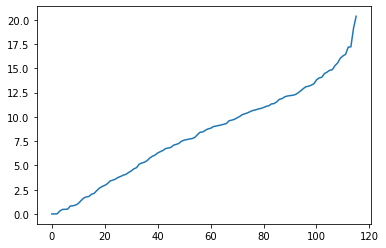

In [105]:
plt.plot(eigenvalues_laplacian)
plt.show()

## Topological


👉 **But graphs can also be studied from a topological perspective.**

Instead of focusing only on direct connections, topology asks:

- Are there loops in the network?

- How many independent cycles or holes exist?

- How does the structure of connections persist as we vary thresholds?

This is where concepts like Betti numbers and persistent homology come in.


**Why Topology?**

- Graphs = local connectivity (pairwise links).

- Topology = higher-order structure (loops, voids, persistent patterns).

**For example:**

- Betti-0 counts connected components (isolated subgraphs).

- Betti-1 counts loops/cycles (closed paths of connectivity).

- Persistent homology tracks how these features appear/disappear across scales (e.g., thresholding the connectivity matrix at different levels).

✅ So the topological view complements graph-theoretic measures by capturing global, multi-scale organization of brain networks — not just individual nodes or paths.

In [114]:
!python

Python 3.6.10 | packaged by conda-forge | (default, Apr 24 2020, 16:44:11) 
[GCC 7.3.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> 
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
KeyboardInterrupt
>>> 

In [116]:
!pip install --upgrade pip
!pip install -U setuptools
!pip install -U Cython
!pip install Ripser

In [117]:
from ripser import ripser
import diagram2vec

In [118]:
# reverse matrix to add higher correlated edges first to the filtration
R_filtered = 1 - np.abs(R[0])

In [119]:
# compute persistence diagram of the network
diagram_R = ripser(R_filtered, distance_matrix=True)["dgms"]
diagram_R

[array([[0.        , 0.06749164],
        [0.        , 0.06972995],
        [0.        , 0.07522405],
        [0.        , 0.08077884],
        [0.        , 0.08343564],
        [0.        , 0.08546077],
        [0.        , 0.08668683],
        [0.        , 0.09399746],
        [0.        , 0.10622823],
        [0.        , 0.11933955],
        [0.        , 0.12376116],
        [0.        , 0.12503786],
        [0.        , 0.12516549],
        [0.        , 0.12586477],
        [0.        , 0.13735695],
        [0.        , 0.1421155 ],
        [0.        , 0.14272501],
        [0.        , 0.14750297],
        [0.        , 0.14859542],
        [0.        , 0.14894207],
        [0.        , 0.14911638],
        [0.        , 0.15761195],
        [0.        , 0.16129711],
        [0.        , 0.16303331],
        [0.        , 0.1672207 ],
        [0.        , 0.16960034],
        [0.        , 0.17343432],
        [0.        , 0.17461735],
        [0.        , 0.17495883],
        [0.   

In [120]:
# vectorize persistent diagram
betti_curve = diagram2vec.persistence_curve(diagram_R)
betti_curve

array([[[115., 115., 115., 115., 115., 115., 115., 113., 112., 108.,
         107., 106., 105., 101., 100.,  94.,  93.,  89.,  85.,  83.,
          80.,  74.,  67.,  64.,  59.,  54.,  51.,  49.,  44.,  41.,
          36.,  33.,  26.,  24.,  22.,  21.,  18.,  16.,  16.,  12.,
          12.,  11.,  10.,  10.,   9.,   8.,   7.,   6.,   5.,   3.,
           2.,   1.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   3.,
           5.,   8.,  10.,  14.,  17.,  12.,  13.,  14.,  14.,  14.,
          18.,  22

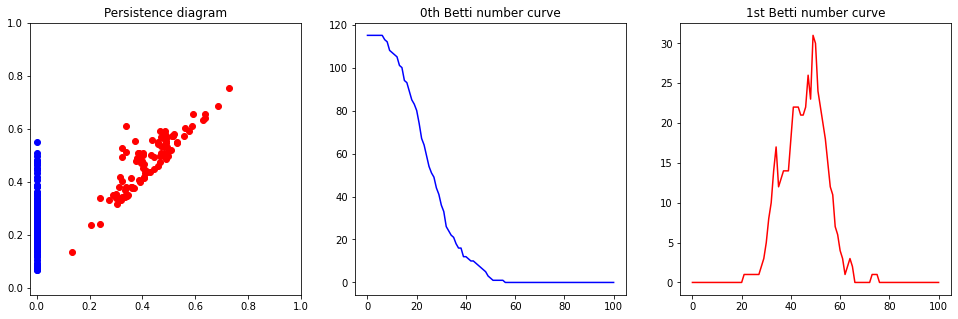

In [121]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.5,5))
ax1.set_title("Persistence diagram")
ax1.set_xlim(-0.025,1)
ax1.set_ylim(-0.025,1)
ax1.scatter(diagram_R[0][:,0], diagram_R[0][:,1], c="b")
ax1.scatter(diagram_R[1][:,0], diagram_R[1][:,1], c="r")
ax2.set_title("0th Betti number curve")
ax2.plot(betti_curve[0,0], c="b")
ax3.set_title("1st Betti number curve")
ax3.plot(betti_curve[0,1], c="r")
plt.show()

<details>
<summary><strong>Reflection: How to Read These Plots</strong></summary>

**1. Persistence Diagram (left)**  
- Each red dot = a topological feature (e.g., a loop or connected component).  
- The x-axis = when the feature appears (birth).  
- The y-axis = when it disappears (death).  
- Points far from the diagonal = more persistent features → likely meaningful structural patterns in the brain network.  
- Blue points near the diagonal = short-lived noise.  

---

**2. 0th Betti Number Curve (middle)**  
- Betti-0 = number of connected components.  
- At threshold 0 (left), there are many components (~120), because each node is isolated.  
- As the threshold increases, edges are added, and components merge.  
- Eventually, the curve drops to 1 → the graph becomes fully connected.  

👉 Interpretation: this curve shows how quickly the brain network integrates as edges are added.  
A steeper drop = faster global integration.  

---

**3. 1st Betti Number Curve (right)**  
- Betti-1 = number of loops (independent cycles).  
- Starts at 0 (no loops when nodes are isolated).  
- As edges are added, loops form (curve rises).  
- Peaks when loops are most abundant (here ~30).  
- Drops again when loops “fill in” and become redundant as the graph becomes denser.  

👉 Interpretation: the peak indicates the scale at which the brain network shows the richest cyclic/topological structure.  

---

**🧠 Why This Matters**  
- **Betti-0 curve**: tells us about integration (from fragmented modules → whole network).  
- **Betti-1 curve**: tells us about redundancy and robustness of pathways (loops provide alternative routes).  
- Together, they capture **multi-scale topology** of functional connectivity — beyond what standard graph measures (degree, clustering, centrality) can show.  
</details>

## Machine learning

After extracting different representations of brain networks —
FC matrices (correlations / MI), graph-based and topological features, and spectral characteristics — the next step is to test whether these features can predict diagnosis (COBRE: Schizophrenia vs Control).

Key principles:
- build a feature space (one vector per subject),
- train classifiers (logistic regression, SVC, etc.),
- evaluate fairly with nested cross-validation (inner loop = hyperparameter search, outer loop = generalization),
- avoid data leakage (all preprocessing must happen inside CV folds).

In [122]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [123]:
meta_data =pd.read_table('meta_data.tsv')

In [124]:
meta_data.Dx.unique()

array(['No_Known_Disorder', 'Schizophrenia_Strict', 'Schizoaffective'],
      dtype=object)

In [127]:
output_path ='./cobre/results/cobre_low0.1/'

In [128]:
def get_data(cobre_data):
    del cobre_data['Unnamed: 0']
    data_dict ={}
    for i,column in enumerate(cobre_data.columns):
        for j in range(0,i):
            data_dict[(column, cobre_data.columns[j])] =cobre_data.iloc[i,j]
    return data_dict

In [129]:
data,labels, ids =[], [], []
for path in Path(output_path).iterdir():
    if ".csv" in str(path) and  "embed" in str(path):
        print(path)
        label =meta_data.loc[meta_data.Subjectid ==path.stem[4:-6]]['Dx'].values[0]
        if label!='Schizoaffective':
            labels.append(label)
            cobre_data =pd.read_csv(path).values[:,1:]
            data.append(cobre_data)
            ids.append(path.stem)
         

results/cobre_low0.1/sub-A00027537_embed.csv
results/cobre_low0.1/sub-A00015759_embed.csv
results/cobre_low0.1/sub-A00028805_embed.csv
results/cobre_low0.1/sub-A00020602_embed.csv
results/cobre_low0.1/sub-A00020984_embed.csv
results/cobre_low0.1/sub-A00012995_embed.csv
results/cobre_low0.1/sub-A00000909_embed.csv
results/cobre_low0.1/sub-A00028405_embed.csv
results/cobre_low0.1/sub-A00010150_embed.csv
results/cobre_low0.1/sub-A00023095_embed.csv
results/cobre_low0.1/sub-A00023330_embed.csv
results/cobre_low0.1/sub-A00028052_embed.csv
results/cobre_low0.1/sub-A00023158_embed.csv
results/cobre_low0.1/sub-A00014590_embed.csv
results/cobre_low0.1/sub-A00018129_embed.csv
results/cobre_low0.1/sub-A00000368_embed.csv
results/cobre_low0.1/sub-A00024301_embed.csv
results/cobre_low0.1/sub-A00022837_embed.csv
results/cobre_low0.1/sub-A00035836_embed.csv
results/cobre_low0.1/sub-A00022835_embed.csv
results/cobre_low0.1/sub-A00037564_embed.csv
results/cobre_low0.1/sub-A00024684_embed.csv
results/co

In [130]:
len(labels)

152

In [131]:
len(data)

152

In [132]:
data[0][:,1:].shape

(150, 114)

In [133]:
ts = np.stack(data)
(n_patients, n_steps, n_regions) = ts.shape

In [134]:
# compute correlation networks
R = ConnectivityMeasure(kind="correlation").fit_transform(ts)
R.shape

(152, 115, 115)

#### FC features

In [135]:
fc_features =np.stack([r[np.triu_indices(r.shape[0], k = 0)] for r in R])

In [136]:
param_grid = [
    {'C': [0.01, 0.1, 1, 3, 10], 'solver': ['liblinear'], 'penalty': ['l1','l2'], 'random_state': [1380]}
]
model_to_tune = LogisticRegression()

In [137]:
#!g1.4
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1380)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1380)

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=-1
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, fc_features, labels, cv=outer_cv, n_jobs=-1, scoring='f1_macro')
print(f"The mean score using nested cross-validation is: "
      f"{test_score.mean():.3f} ± {test_score.std():.3f}")

The mean score using nested cross-validation is: 0.658 ± 0.099


In [138]:
#!g1.4
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


param_grid = [
    {'C': [0.01, 0.1], 'kernel': ['linear', 'rbf'], 'random_state': [1380]}
]

model_to_tune = SVC()

In [139]:
#!g1.4
from sklearn.model_selection import cross_val_score, KFold

# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1380)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1380)

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=-1
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, fc_features, labels, cv=outer_cv, n_jobs=-1, scoring = 'f1_macro')
print(f"The mean score using nested cross-validation is: "
      f"{test_score.mean():.3f} ± {test_score.std():.3f}")

The mean score using nested cross-validation is: 0.616 ± 0.141


#### Topological features

In [140]:
# topological features
R_filtration = 1 - np.abs(R)

diagrams = []

for i, R_filtered in enumerate(R_filtration):
    diagram = ripser(R_filtered, distance_matrix=True)["dgms"]
    diagrams.append(diagram)

In [141]:
X_topological = diagram2vec.persistence_curve(diagrams, quantity="persistence", m=40)

In [142]:
X_topological[:,0].shape

(152, 40)

In [143]:
dataset = datasets.fetch_atlas_aal(version='SPM12', data_dir=None, url=None, resume=True, verbose=1)
len(dataset.labels)

116

In [144]:
clf = DecisionTreeClassifier(random_state=42, max_depth=5)
cross_val_score(clf, X_topological[:,1], labels, cv=10).mean()

0.5800000000000001

#### Graph features

In [145]:
R_thresholded = np.copy(R)
for i in range(R_thresholded.shape[0]):
    np.fill_diagonal(R_thresholded[i], 0)

R_thresholded[R_thresholded < 0.47] = 0.0

In [146]:
# graph features
X_graph = np.zeros((n_patients, n_regions*5))

for i in range(R_thresholded.shape[0]):
    
    G = nx.from_numpy_array(R_thresholded[i])
    
    degree = np.array([degree[1] for degree in nx.degree(G)])
    neighbor_degree_avg = np.array(list(nx.average_neighbor_degree(G).values()))
    centrality_betweenness = np.array(list(nx.betweenness_centrality(G).values()))
    centrality_closeness = np.array(list(nx.closeness_centrality(G).values()))
    clustering_coefficient = np.array(list(nx.clustering(G).values()))
    
    feature_i = np.concatenate((degree, neighbor_degree_avg, centrality_betweenness, centrality_closeness, clustering_coefficient))
    X_graph[i] = feature_i


In [147]:
cross_val_score(clf, X_graph, labels, cv=10).mean()

0.5545833333333333

#### Spectral features

In [148]:
# spectral features (eigher spectrum or Laplacian spectrum)
X_spectral = np.zeros((n_patients, n_regions))

for i in range(R_thresholded.shape[0]):
    eigenvalues_i, _ = np.linalg.eigh(R_thresholded[i])
    X_spectral[i] = eigenvalues_i

In [149]:
cross_val_score(clf, X_spectral, labels, cv=10).mean()

0.50625

#### Features concatenation

In [150]:
cross_val_score(clf, np.concatenate((X_graph, X_spectral, X_topological[:,1]), axis=1), labels, cv=10).mean()

0.5333333333333333

**HW Task**


1) Repeat the feature extraction and machine learning pipeline on mutual information matrices, combine all features including from FC (5 points)

2) Add 2 feature selection + 2 dimension reduction methods (5 points)

3) Write report with comparison of several different FC builgings + different ML methods, describe what method with which number of features works better and why
